In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn import model_selection
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score, f1_score,plot_confusion_matrix,plot_roc_curve



In [4]:
import numpy as np 
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)

train = pd.read_csv("../input/preprocessed-fraud/train_preprocessed.csv")
test = pd.read_csv("../input/preprocessed-fraud/test_preprocessed.csv")

In [15]:
def submit(y_pred):
    sample = pd.read_csv('../input/submission-template/mock_submission_real.csv')
    sample.isFraud = y_pred
    sub_name = 'submission.csv'
    sample.to_csv(sub_name, index=False)

In [6]:
y = train[['isFraud']]

In [7]:
X = train.drop(['isFraud'], axis = 1)
del train

In [8]:
# over = RandomOverSampler(sampling_strategy=0.25)
# under = RandomUnderSampler(sampling_strategy=0.25)
# X_over, y_over = over.fit_resample(X, y)


In [9]:
# X_f, y_f = under.fit_resample(X_over, y_over)

## Logistic regression

In [10]:
pred_valid = np.zeros(X.shape[0])
pred_test = np.zeros(test.shape[0])
cmx = []
roc_auc_scores = []

In [11]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle = True)
for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
    clf = LogisticRegression(solver='liblinear',class_weight='balanced')
    
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    clf.fit(X_train,y_train.values.ravel())
    pred_valid[valid_index] = clf.predict_proba(X_valid)[:, 1]
    pred_test += clf.predict_proba(test)[:, 1] / folds.n_splits
    roc_auc_scores.append(roc_auc_score(y_valid, pred_valid[valid_index]))
    print('Fold %2d AUC : %.6f' % (fold_n + 1, roc_auc_score(y_valid, pred_valid[valid_index]))) 
    
    # Confusion matrix
    cmx.append(confusion_matrix(y_valid, pred_valid[valid_index].round()))
    
    # Features importance
#     feature_imp = clf.get_booster().get_score(importance_type='gain')
#     main_features.append(feature_imp)
    
print('Full AUC score %.6f' % roc_auc_score(y, pred_valid))

Fold  1 AUC : 0.845997
Fold  2 AUC : 0.849464
Fold  3 AUC : 0.849637
Fold  4 AUC : 0.850836
Fold  5 AUC : 0.853225
Full AUC score 0.849823


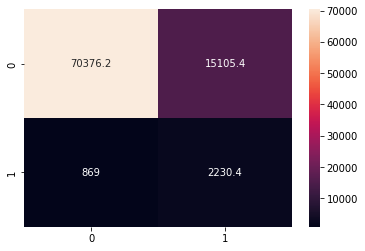

In [12]:
conf_matrix = np.average(cmx, axis= 0)
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.show()


In [16]:
submit(pred_test)